In [1]:
import pickle
import torch
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from pathlib import Path

Load data

In [2]:
data_dir = Path("../data/preprocessed").absolute()
# with open(data_dir / 'networkx_graph.pkl', 'rb') as f:
#     graph = pickle.load(f)
node_info = pd.read_pickle(data_dir / "node_info.pkl")
edge_info = pd.read_pickle(data_dir / "edge_info.pkl")

In [3]:
edge_info.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940619238582,720575940634854554,AVLP_R,35,ACH
1,720575940634034839,720575940660217473,AL_R,38,SER
2,720575940612615570,720575940604789676,EB,26,GABA
3,720575940614901215,720575940626983952,PRW,70,GABA
4,720575940627312104,720575940625498512,SMP_R,28,GLUT


In [7]:
# exclude optic neurons

node_info = node_info[node_info["super_class"] != "optic"]
edge_info = edge_info[
    edge_info["pre_root_id"].isin(node_info["root_id"])
    & edge_info["post_root_id"].isin(node_info["root_id"])
]

In [8]:
print(f"|V|={len(node_info)}, |E|={len(edge_info)}")

|V|=51405, |E|=1301936


How many neurotransmitter types are there?

In [9]:
edge_info["nt_type"].value_counts()

nt_type
ACH     755659
GABA    284311
GLUT    224321
SER      21103
DA       13169
OCT       3373
Name: count, dtype: int64

Build node embedding: build a node2vec embedding for each neurotransmitter type, and concatenate the feature vectors

In [10]:
nt_types = edge_info["nt_type"].unique()
dim_per_nt = 8
features = []
embeddings = []
for nt_type in nt_types:
    edges = edge_info[edge_info["nt_type"] == nt_type]
    g = nx.from_pandas_edgelist(
        edges,
        source="pre_root_id",
        target="post_root_id",
        edge_attr=["neuropil", "syn_count", "nt_type"],
        create_using=nx.DiGraph,
    )
    missing_nodes = set(node_info["root_id"]) - set(g.nodes)
    g.add_nodes_from(missing_nodes)
    assert len(g) == len(node_info)
    print("building node2vec")
    node2vec = Node2Vec(
        g,
        dimensions=dim_per_nt,
        walk_length=30,
        num_walks=50,
        workers=15,
        weight_key="syn_count",
    )
    print("fitting model")
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    emb_df = pd.DataFrame(
        model.wv.vectors,
        index=np.array([int(x) for x in model.wv.index_to_key], dtype=np.int64),
        columns=[f"{nt_type}_{i}" for i in range(dim_per_nt)],
    )
    embeddings.append(emb_df)

building node2vec


Computing transition probabilities:   0%|          | 0/51405 [00:00<?, ?it/s]

Generating walks (CPU: 15): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


fitting model
building node2vec


Computing transition probabilities:   0%|          | 0/51405 [00:00<?, ?it/s]

Generating walks (CPU: 15): 100%|██████████| 3/3 [00:00<00:00, 10.71it/s]


fitting model
building node2vec


Computing transition probabilities:   0%|          | 0/51405 [00:00<?, ?it/s]

Generating walks (CPU: 15): 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]


fitting model
building node2vec


Computing transition probabilities:   0%|          | 0/51405 [00:00<?, ?it/s]

Generating walks (CPU: 15): 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


fitting model
building node2vec


Computing transition probabilities:   0%|          | 0/51405 [00:00<?, ?it/s]

Generating walks (CPU: 15): 100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


fitting model
building node2vec


Computing transition probabilities:   0%|          | 0/51405 [00:00<?, ?it/s]

Generating walks (CPU: 15): 100%|██████████| 3/3 [00:00<00:00, 13.76it/s]


fitting model


In [11]:
# with open("embeddings_all.pkl", "wb") as f:
#     pickle.dump(embeddings, f)

In [13]:
superclass_id2name = dict(enumerate(node_info["super_class"].unique()))
superclass_name2id = {name: id for id, name in superclass_id2name.items()}
class_id2name = dict(enumerate(node_info["class"].unique()))
class_name2id = {name: id for id, name in class_id2name.items()}
neuron_superclass = [superclass_name2id[x] if not pd.isna(x) else -1 for x in node_info['super_class']]
neuron_class = [class_name2id[x] if not pd.isna(x) else -1 for x in node_info['class']]

In [16]:
from functools import reduce

embedding_df = reduce(
    lambda df1, df2: df1.merge(df2, left_index=True, right_index=True), embeddings
)
embedding_df = embedding_df.merge(
    node_info[["root_id", "class", "super_class"]], left_index=True, right_on="root_id"
)
embedding_df["neuron_superclass"] = [
    superclass_name2id[x] for x in embedding_df["super_class"]
]
embedding_df["neuron_class"] = [
    class_name2id[x] if not pd.isna(x) else -1 for x in embedding_df["class"]
]
embedding_df = embedding_df.set_index("root_id")
embedding_df = embedding_df.drop(columns=["class", "super_class"])

In [23]:
embedding_df.head()

,ACH_0,ACH_1,ACH_2,ACH_3,ACH_4,ACH_5,ACH_6,ACH_7,SER_0,SER_1,...,OCT_0,OCT_1,OCT_2,OCT_3,OCT_4,OCT_5,OCT_6,OCT_7,neuron_superclass,neuron_class
root_id,,,,,,,,,,,,,,,,,,,,,
720575940621280688,-1.994096,1.659962,0.173805,1.904331,-1.003737,0.007529,2.040049,1.149608,-0.031015,0.112028,...,-0.052726,-0.018409,0.125545,0.011671,-0.201100,-0.084129,0.079007,0.091844,1,28
720575940629174889,-1.548181,2.693620,0.307061,1.393276,0.695419,1.939965,0.429204,-0.471451,-0.196538,1.177711,...,-0.076618,0.003726,-0.122438,0.123537,0.026799,-0.006937,0.122290,-0.039164,1,28
720575940637132389,-1.595484,2.108573,0.002348,0.721139,0.141971,1.278273,0.014214,-1.051259,0.270894,0.996614,...,-0.063444,-0.070393,-0.102671,0.108756,-0.014874,0.058635,0.098326,0.118308,1,28
720575940654777505,0.219010,4.697111,-9.753252,1.139971,7.852001,-0.133780,5.475981,3.042072,0.044153,-0.120132,...,-0.115370,-0.114281,0.081709,0.012190,0.123858,0.104005,-0.040010,-0.095839,1,-1
720575940616159371,0.180437,4.519468,-9.247948,1.068967,7.532286,-0.264914,5.227978,2.873947,-0.056779,0.121342,...,-0.117057,0.123954,0.118786,-0.058143,0.070720,-0.007271,-0.052550,-0.115174,1,-1


In [24]:
import torch
features = torch.tensor(embedding_df[[f"{nt}_{i}" for nt in nt_types for i in range(dim_per_nt)]].values)
labels = torch.tensor(embedding_df["neuron_class"].values, dtype=torch.long)
mask = torch.tensor(embedding_df["neuron_class"].values) != -1
features = features[mask]
labels = labels[mask]

In [25]:
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset = TensorDataset(features, labels)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2])

In [26]:
import torch.nn as nn

class MyMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [27]:
labels.max(), len(class_id2name)

(tensor(28), 29)

In [28]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()

mlp_model = MyMLP(input_dim=48, output_dim=len(class_id2name), hidden_dim=16)
mlp_model = mlp_model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(mlp_model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
def get_accuracy(model, loader):
    num_correct = 0
    num_total = 0
    for inputs, targets in loader:
        outputs = model(inputs.to(device))
        preds = torch.argmax(outputs, dim=1)
        num_correct += torch.sum(preds == targets.to(device))
        num_total += len(targets)
    return num_correct / num_total

In [30]:
num_epochs = 50
loss_hist = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = mlp_model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
    print(f'Epoch: {epoch}/{num_epochs}, Loss: {loss.item():.4f}')
    if epoch % 10 == 0:
        print(f"Val accuracy: {get_accuracy(mlp_model, val_loader):.4f}")

Epoch: 0/50, Loss: 1.0141
Val accuracy: 0.6622
Epoch: 1/50, Loss: 0.6996
Epoch: 2/50, Loss: 0.4097
Epoch: 3/50, Loss: 0.3953
Epoch: 4/50, Loss: 0.5861
Epoch: 5/50, Loss: 0.6899
Epoch: 6/50, Loss: 0.3925
Epoch: 7/50, Loss: 0.4337
Epoch: 8/50, Loss: 0.6364
Epoch: 9/50, Loss: 0.3418
Epoch: 10/50, Loss: 0.4576
Val accuracy: 0.8259
Epoch: 11/50, Loss: 0.4576
Epoch: 12/50, Loss: 0.4252
Epoch: 13/50, Loss: 0.4273
Epoch: 14/50, Loss: 0.5182
Epoch: 15/50, Loss: 0.3735
Epoch: 16/50, Loss: 0.4943
Epoch: 17/50, Loss: 0.2678
Epoch: 18/50, Loss: 0.3268
Epoch: 19/50, Loss: 0.2324
Epoch: 20/50, Loss: 0.5862
Val accuracy: 0.8398
Epoch: 21/50, Loss: 0.4142
Epoch: 22/50, Loss: 0.2917
Epoch: 23/50, Loss: 0.6464
Epoch: 24/50, Loss: 0.7244
Epoch: 25/50, Loss: 0.3491
Epoch: 26/50, Loss: 0.2942
Epoch: 27/50, Loss: 0.3602
Epoch: 28/50, Loss: 0.3005
Epoch: 29/50, Loss: 0.4403
Epoch: 30/50, Loss: 0.4397
Val accuracy: 0.8511
Epoch: 31/50, Loss: 0.4236
Epoch: 32/50, Loss: 0.4225
Epoch: 33/50, Loss: 0.4327
Epoch: 3

Text(0, 0.5, 'Training loss')

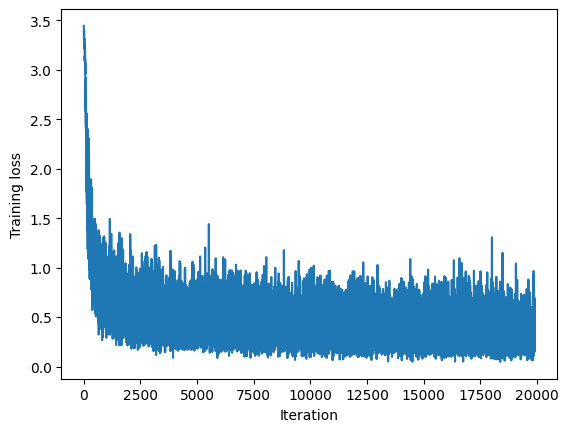

In [31]:
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

In [32]:
pred_all = []
target_all = []
for inputs, targets in val_loader:
    outputs = mlp_model(inputs.to(device))
    preds = torch.argmax(outputs, dim=1)
    pred_all.append(preds.cpu().numpy())
    target_all.append(targets.numpy())
pred_all = np.concatenate(pred_all)
target_all = np.concatenate(target_all)

/tmp/ipykernel_1527706/1351610772.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cmat))


Text(0.5, 1.0, 'Confusion matrix (log scale)')

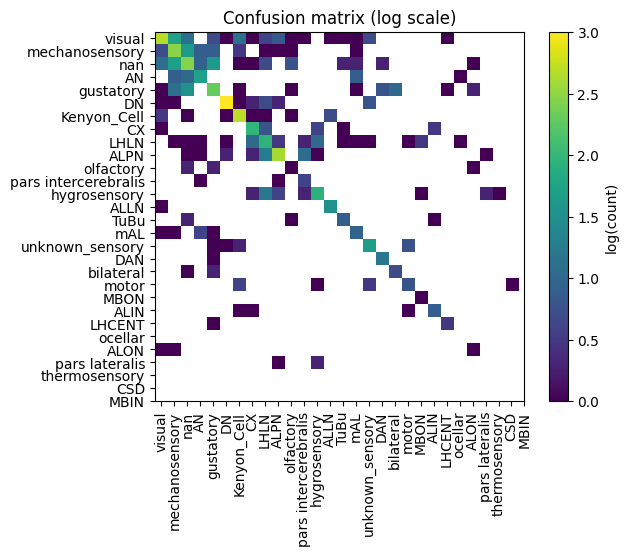

In [40]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(pred_all, target_all)
plt.imshow(np.log10(cmat))
# plt.imshow(cmat)
plt.colorbar(label="log(count)")
plt.xticks(
    range(len(class_id2name)),
    [class_id2name[i] for i in range(len(class_id2name))],
    rotation=90,
)
plt.yticks(
    range(len(class_id2name)),
    [class_id2name[i] for i in range(len(class_id2name))],
)
plt.title("Confusion matrix (log scale)")

In [45]:
get_accuracy(mlp_model, test_loader)

tensor(0.8662, device='cuda:0')

Text(0, 0.5, '# neurons')

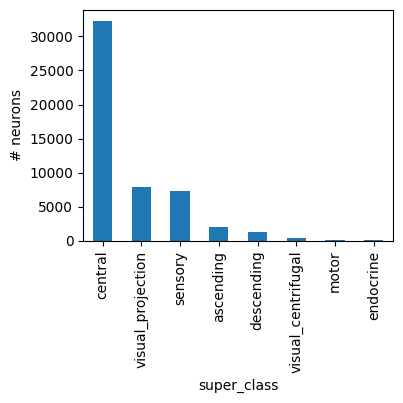

In [57]:
node_info['super_class'].value_counts().plot.bar(figsize=(4, 3))
plt.ylabel("# neurons")

Text(0, 0.5, '# neurons')

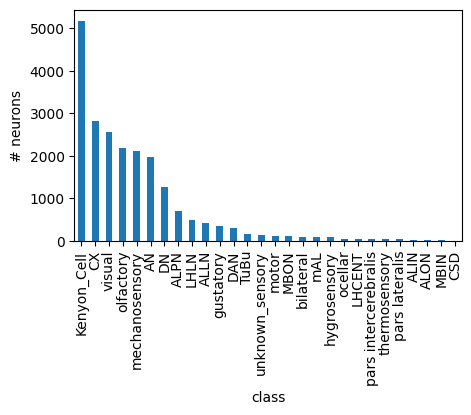

In [56]:
node_info['class'].value_counts().plot.bar(figsize=(5, 3))
plt.ylabel("# neurons")

Text(0, 0.5, '# neurons')

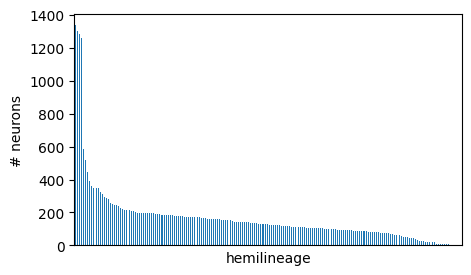

In [55]:
node_info['hemilineage'].value_counts().plot.bar(figsize=(5, 3))
plt.xticks([])
plt.ylabel("# neurons")

Text(0, 0.5, '# connections')

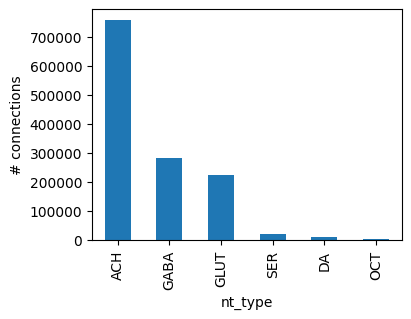

In [60]:
edge_info['nt_type'].value_counts().plot.bar(figsize=(4, 3))
plt.ylabel("# connections")